In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
data=pd.read_csv(r"C:\Users\30697\KAGGLE\Energy Consumption - Time Series\individual+household+electric+power+consumption (1)\household_power_consumption.txt",
    sep=";",na_values="?",low_memory=False)

In [20]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


In [29]:
data.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [38]:
data = data.ffill().bfill() # because our dataset is time-series we fill forward/backward to preserve the trend 

In [39]:
data.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [42]:
data["Datetime"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d/%m/%Y %H:%M:%S")
# we create a new column and set it at the format meaningfull for our modelling

In [43]:
data = data.drop(columns=["Date", "Time"])
data = data.set_index("Datetime")

In [45]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # as almost all the time we will scale our data

In [67]:
data_scaled = pd.DataFrame(
    scaler.fit_transform(data),
    index=data.index,
    columns=data.columns)

In [69]:
plot_data = data.loc["2008-01-01":"2009-12-31", "Global_active_power"]
# We plot 2 random years to check for seasonality in our data

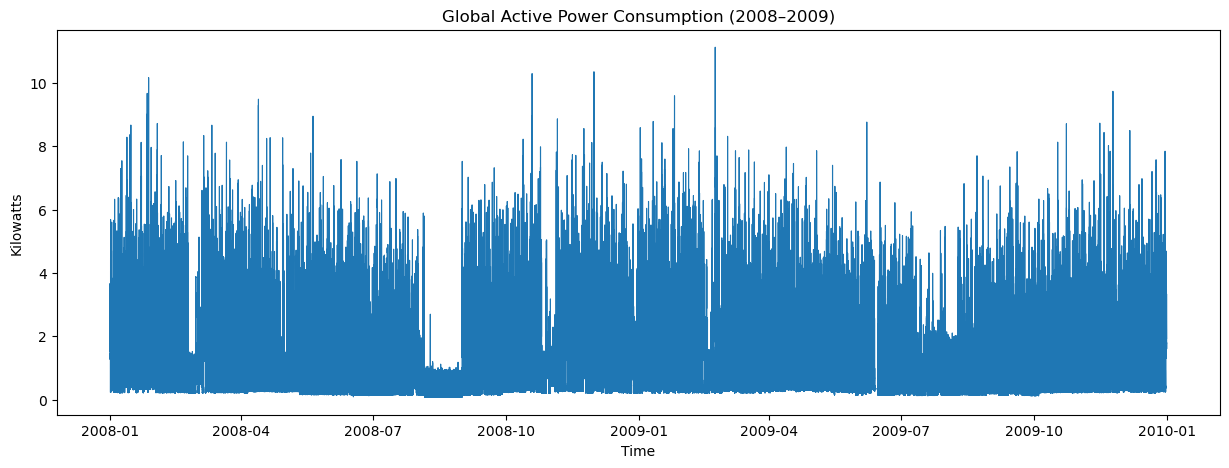

In [71]:
plt.figure(figsize=(15,5))
plt.plot(plot_data, linewidth=0.8)
plt.title("Global Active Power Consumption (2008–2009)")
plt.xlabel("Time")
plt.ylabel("Kilowatts")
plt.show()

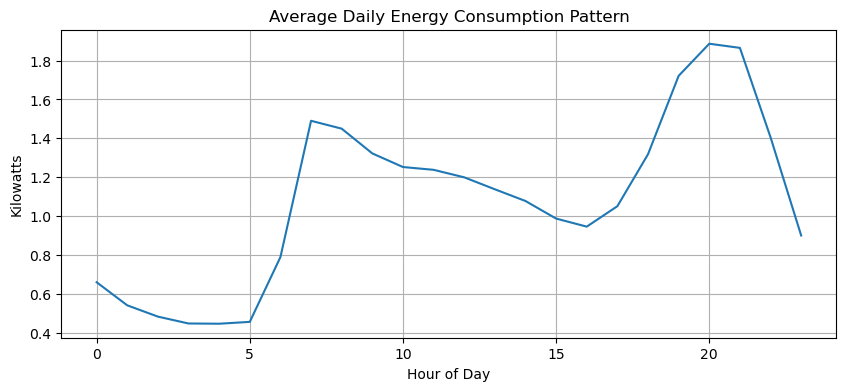

In [73]:
daily_profile = data.groupby(data.index.hour)["Global_active_power"].mean()
plt.figure(figsize=(10,4))
plt.plot(daily_profile)
plt.title("Average Daily Energy Consumption Pattern")
plt.xlabel("Hour of Day")
plt.ylabel("Kilowatts")
plt.grid(True)
plt.show()


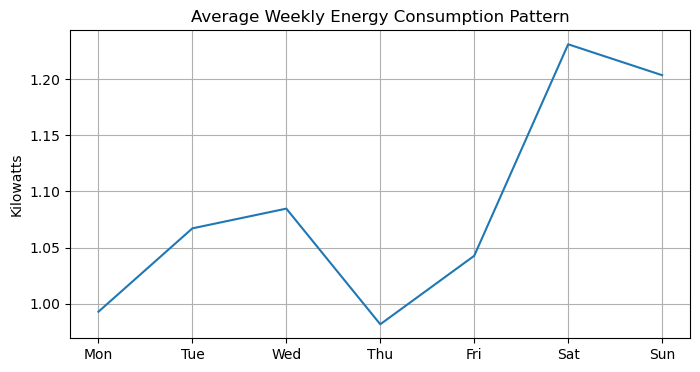

In [75]:
weekly_profile = data.groupby(data.index.weekday)["Global_active_power"].mean()

plt.figure(figsize=(8,4))
plt.plot(
    ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"],
    weekly_profile
)
plt.title("Average Weekly Energy Consumption Pattern")
plt.ylabel("Kilowatts")
plt.grid(True)
plt.show()

In [77]:
# from the first graph we can see there is a little seasonality in the data.
# from the second graph we can tell what hours the consumption is made in average, which ofcthe peak is after work hours.
# from the 3rd graph we can see that after friday the consumption skyrockets.that because ppl are at their houses these days

In [102]:
hourly_data = data.resample("h").mean()# we resample to hourly to make our dataset smaller and meaningfull
hourly_data.shape

(34589, 7)

In [104]:
def create_supervised(data, target_col="Global_active_power", n_lags=24):
    # We define a function that  will create our new data for our time-series model.
    X, y = [], []
    values = data.values
    target_idx = data.columns.get_loc(target_col)
    
    for i in range(n_lags, len(data)):
        X.append(values[i-n_lags:i, :]) 
            # past n_lags hours
        y.append(values[i, target_idx])       et
            # next hour targ
    X = np.array(X)
    y = np.array(y)
    
    X = X.reshape(X.shape[0], -1)
    return X, y

In [106]:
n_lags = 24
X, y = create_supervised(hourly_data, n_lags=n_lags)

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # keep temporal order
)

In [119]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train) 

LinearRegression()

In [127]:
def recursive_forecast(lr_model, X_test, n_lags=24, horizon=24):
       # We start with the last input window
    history = X_test[-1].copy()  # last available window
    predictions = []

    feature_size = X_test.shape[1] // n_lags  # number of features per timestep

    for _ in range(horizon):
        # Predict next step
        yhat = lr_model.predict(history.reshape(1, -1))[0]
        predictions.append(yhat)

        # Shift window left by one time step
        history = np.roll(history, -feature_size)

        # Insert prediction as last timestep for target feature
        history[0::feature_size] = yhat  # replace GAP for last timestep

    return np.array(predictions)

In [129]:
horizon = 24
predictions_24h = recursive_forecast(lr_model, X_test, n_lags=n_lags, horizon=horizon)
print(predictions_24h)

[ 1.08873093  1.19375958  0.56065541 -0.02052107  0.16285373 -0.15263895
 -0.52928919 -1.34823512 -3.08122244 -4.24771953 -3.00983235 -3.85093512
 -3.73389966 -5.25411042 -5.81411662 -4.81756093 -3.85069377 -2.02578015
 -1.07180606 -1.34948124 -0.02660106  1.09896459  2.76819548  3.43102969]


In [131]:
actual_24h = y_test[-horizon:]

In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [133]:
mae_24h = mean_absolute_error(actual_24h, predictions_24h)
rmse_24h = np.sqrt(mean_squared_error(actual_24h, predictions_24h))

print(mae_24h)
print(rmse_24h)

24-hour Recursive Forecast MAE: 2.9576
24-hour Recursive Forecast RMSE: 3.8452


In [135]:
### GRU Model

In [156]:
def create_gru_data(data, target_col="Global_active_power", n_lags=24):
    X, y = [], []
    values = data.values
    target_idx = data.columns.get_loc(target_col)

    for i in range(n_lags, len(data)):
        X.append(values[i-n_lags:i, :]) 
        y.append(values[i, target_idx]) 

    return np.array(X), np.array(y)

In [162]:
X, y = create_gru_data(hourly_data, n_lags=24)

In [168]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

In [170]:
n_features = X_train.shape[2]

X_train_flat = X_train.reshape(-1, n_features)
X_test_flat  = X_test.reshape(-1, n_features)

X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled  = scaler.transform(X_test_flat).reshape(X_test.shape)

In [180]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled  = y_scaler.transform(y_test.reshape(-1,1))

In [164]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

In [166]:
gru_model=Sequential([
    GRU(64,input_shape=(X.shape[1],X.shape[2]),return_sequences=False),
    Dropout(0.2),
    Dense(32,activation="relu"),
    Dense(1)
])

In [172]:
gru_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

In [174]:
gru_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                14016     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,129
Trainable params: 16,129
Non-trainable params: 0
_________________________________________________________________


In [176]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [182]:
history = gru_model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,   # validation from TRAIN only
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping_cb],
    verbose=1
)

Epoch 1/50
692/692 [==============================] - 13s 13ms/step - loss: 0.0114 - mae: 0.0767 - val_loss: 0.0075 - val_mae: 0.0630
Epoch 2/50
692/692 [==============================] - 9s 13ms/step - loss: 0.0092 - mae: 0.0683 - val_loss: 0.0071 - val_mae: 0.0585
Epoch 3/50
692/692 [==============================] - 12s 17ms/step - loss: 0.0089 - mae: 0.0665 - val_loss: 0.0068 - val_mae: 0.0581
Epoch 4/50
692/692 [==============================] - 21s 30ms/step - loss: 0.0086 - mae: 0.0650 - val_loss: 0.0066 - val_mae: 0.0570
Epoch 5/50
692/692 [==============================] - 15s 22ms/step - loss: 0.0084 - mae: 0.0638 - val_loss: 0.0067 - val_mae: 0.0552
Epoch 6/50
692/692 [==============================] - 25s 36ms/step - loss: 0.0082 - mae: 0.0630 - val_loss: 0.0074 - val_mae: 0.0588
Epoch 7/50
692/692 [==============================] - 22s 32ms/step - loss: 0.0080 - mae: 0.0617 - val_loss: 0.0066 - val_mae: 0.0559
Epoch 8/50
692/692 [==============================] - 22s 31ms/

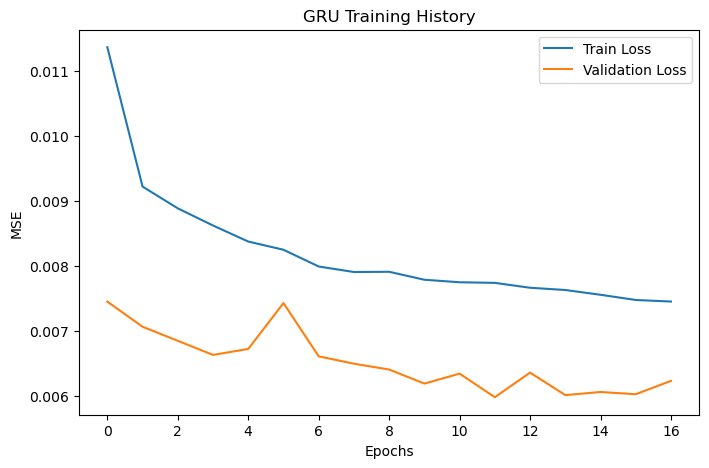

In [184]:
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("GRU Training History")
plt.show()

In [186]:
y_pred_scaled = gru_model.predict(X_test_scaled)


217/217 [==============================] - 2s 4ms/step


In [188]:
# Inverse transform
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test_scaled.reshape(-1,1))

In [190]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(mae)
print(rmse)

Test MAE (kW): 0.3273
Test RMSE (kW): 0.4726


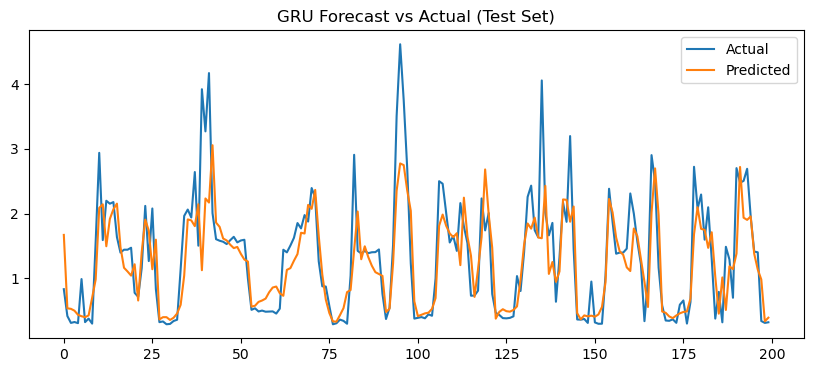

In [192]:
plt.figure(figsize=(10,4))
plt.plot(y_true[:200], label="Actual")
plt.plot(y_pred[:200], label="Predicted")
plt.legend()
plt.title("GRU Forecast vs Actual (Test Set)")
plt.show()

In [ ]:
# The GRU model as expected achieves way better performance from our base model.
# The low MAE and RMSE indicates that the model captures short-term dynamics effectively despite the missing data.
